In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 导入标注

In [2]:
root_path = "/runspace/liubin/tianchi2018_fashion-tag/data/fashionAI_attributes_train_20180222"
csv_path = os.path.join(root_path, "Annotations/label.csv")
df_train = pd.read_csv(csv_path, header=None)
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


In [3]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels', 
           'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels', 
           'pant_length_labels']
len(classes)

8

In [4]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 8393


,image_id,class,label
0,Images/collar_design_labels/4d8a38b29930a403e5...,collar_design_labels,nnynn
1,Images/collar_design_labels/bd0981f231180d2b00...,collar_design_labels,nynnn
2,Images/collar_design_labels/26937e1724feadfe39...,collar_design_labels,ynnnn
3,Images/collar_design_labels/cf4140ec542887270f...,collar_design_labels,nynnn
4,Images/collar_design_labels/50644b2b9de045f2d1...,collar_design_labels,nynnn


### 导入数据

In [5]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)

for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
    if len(tmp_label) > n_class:
        print(df_load['image_id'][i])
    X[i] = cv2.resize(cv2.imread(os.path.join(root_path, df_load['image_id'][i])), (width, width))
    y[i][tmp_label.find('y')] = 1

100%|██████████| 8393/8393 [00:39<00:00, 212.07it/s]


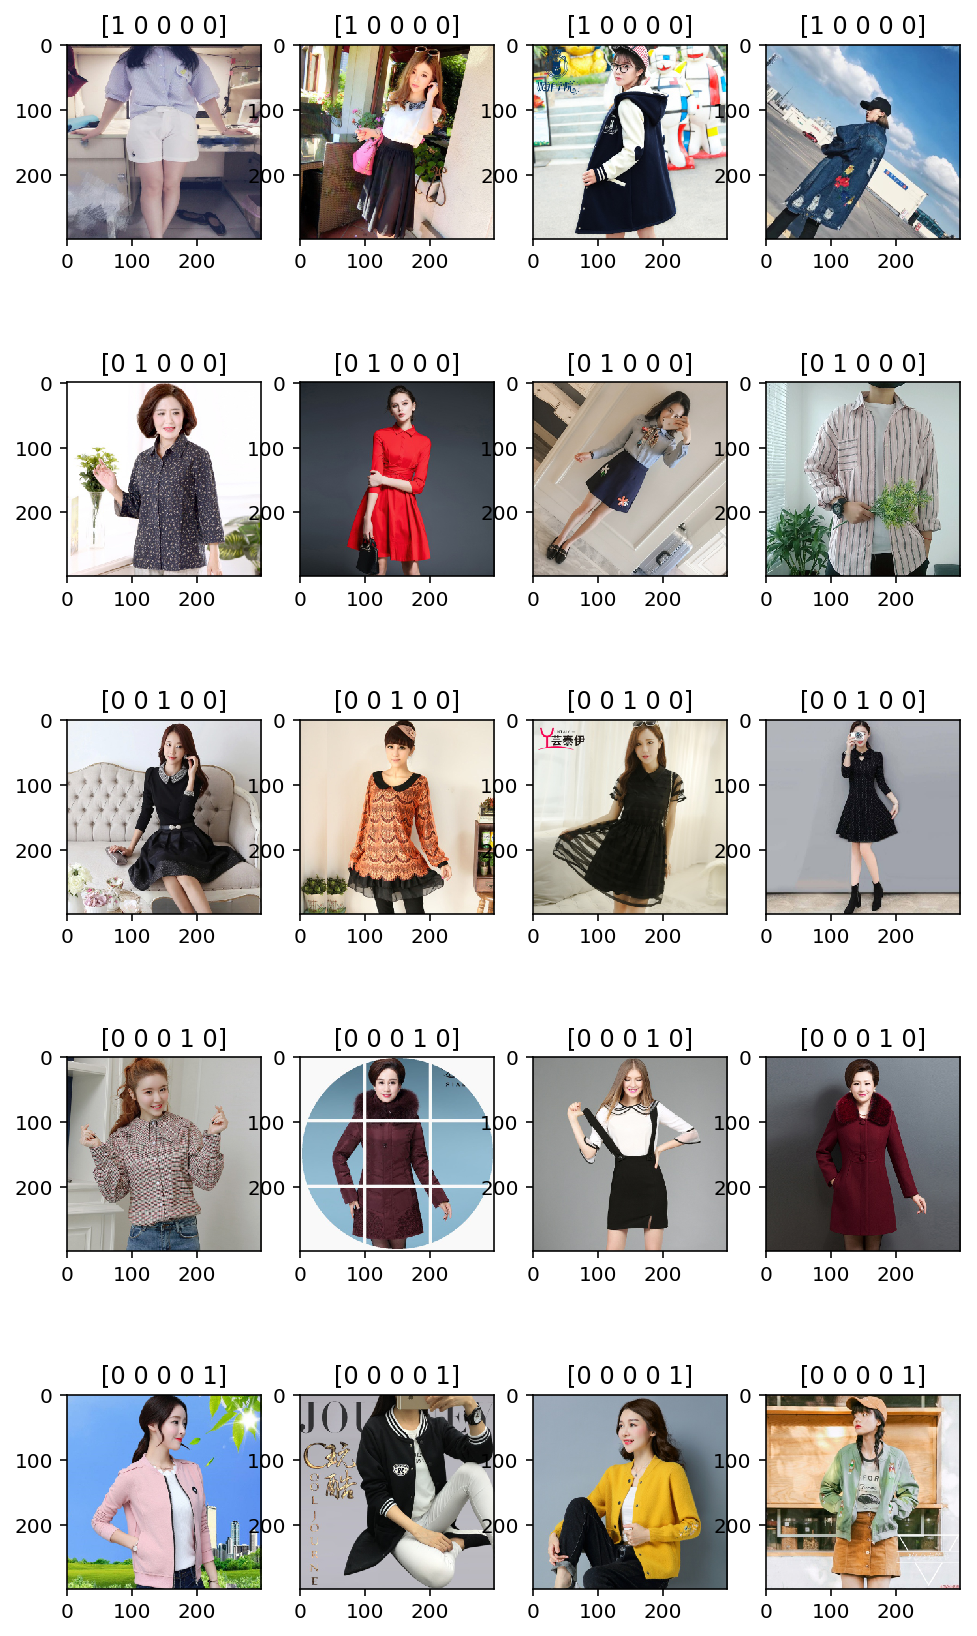

In [6]:
NN = 4
plt.figure(figsize=(NN*2, n_class*3))
for i in range(n_class):
    cnt = 0
    for j in range(n):
        if y[j][i] == 1:
            cnt += 1
            plt.subplot(n_class, NN, i*NN+cnt)
            plt.imshow(X[j][:, :, ::-1])
            plt.title(y[j])
            if cnt == NN:
                break

### 模型定义

In [7]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.
/home/liubin/miniconda2/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.12, random_state=42)
X_train.shape, y_train.shape

((7385, 299, 299, 3), (7385, 5))

In [ ]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./models/{0}.best.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=32, epochs=80, 
              callbacks=[checkpointer], 
              shuffle=True, 
              validation_split=0.1)

Train on 6646 samples, validate on 739 samples
Epoch 1/80
6646/6646 [==============================] - 193s 29ms/step - loss: 0.9871 - acc: 0.6229 - val_loss: 0.8084 - val_acc: 0.7429

Epoch 00001: val_loss improved from inf to 0.80843, saving model to ./models/collar.best.h5
Epoch 2/80
6646/6646 [==============================] - 160s 24ms/step - loss: 0.6009 - acc: 0.7868 - val_loss: 0.8183 - val_acc: 0.7104

Epoch 00002: val_loss did not improve
Epoch 3/80
6646/6646 [==============================] - 161s 24ms/step - loss: 0.4343 - acc: 0.8501 - val_loss: 0.6644 - val_acc: 0.7713

Epoch 00003: val_loss improved from 0.80843 to 0.66439, saving model to ./models/collar.best.h5
Epoch 4/80
6646/6646 [==============================] - 161s 24ms/step - loss: 0.3354 - acc: 0.8856 - val_loss: 0.6926 - val_acc: 0.7591

Epoch 00004: val_loss did not improve
Epoch 5/80
6646/6646 [==============================] - 160s 24ms/step - loss: 0.2768 - acc: 0.9034 - val_loss: 0.7891 - val_acc: 0.7510


In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [ ]:
model.evaluate(X_train, y_train, batch_size=256)

### 预测结果并保存

In [ ]:
test_root = "/runspace/liubin/tianchi2018_fashion-tag/data/fashionAI_attributes_test_a_20180222"
df_test = pd.read_csv(os.path.join(test_root, 'Tests/question.csv'), header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

In [ ]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

In [ ]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread(os.path.join(test_root, df_load['image_id'][i])), (width, width))

In [ ]:
test_np = model.predict(X_test, batch_size=256)
test_np.shape

In [ ]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

In [ ]:
df_load.to_csv('./result/{}_0326a.csv'.format(prefix_cls), header=None, index=False)